In [ ]:
from pathlib import Path
import pickle
import numpy as np
from PIL import Image
import sys
from matplotlib import pyplot as plt

#Modificada para pegar somente um mapa por imagem e fazer uma imagem com o mesmo mapa de forma aleatória(20 a 50).

#sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")
sys.path.insert(0, r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

#root_dir = f"/home/adriano/projeto_mestrado/modules"
root_dir = Path(r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")
img_dir = f'{root_dir}/Imagens/vessel_data/images'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x'

trein_dir = f'{root_dir}/Training_validation'

#pickle_dir = f'{root_dir}/Vessel_Models_pickle'
#pickle_dir_5 = f'{trein_dir}/Mapas/5_mapas_de_5_imagens'
#pickle_dir_10 = f'{trein_dir}/Mapas/10_mapas_de_10_imagens'
#pickle_dir_40 = f'{trein_dir}/Mapas/160_mapas_de_40_imagens'
pickle_dir_50 = f'{trein_dir}/Mapas/200_mapas_de_50_imagens'

#background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
#background_dir_5 = f'{trein_dir}/Backgrounds/5_backgrounds'
#background_dir_10 = f'{trein_dir}/Backgrounds/10_backgrounds'
#background_dir_40 = f'{trein_dir}/Backgrounds/40_backgrounds'
background_dir_50 = f'{trein_dir}/Backgrounds/50_backgrounds'


#tracados_dir = root_dir/"Artificial_Lines/tracados_bezier"
tracados_dir_maiores = f'{root_dir}/Artificial_Lines/tracados_bezier_maiores'

vetor_pickles = funcoes.ler_diretorios(pickle_dir_50)
array_backgrounds = funcoes.ler_diretorios(background_dir_50)
#array_tracados = funcoes.ler_diretorios(tracados_dir)
array_tracados_maiores = funcoes.ler_diretorios(tracados_dir_maiores)

problema = 0
resultados_not_none = 0
resultados_none = 0

n_random = np.random.randint(0, len(vetor_pickles))  
path_pickle = (pickle_dir_50 + f'/{vetor_pickles[n_random]}')
print(path_pickle)


for j in range(100):
    
    imagem_binaria_sem_artefatos_laterais = None
    while imagem_binaria_sem_artefatos_laterais is None:        

        arquivo_pickle = pickle.load(open(path_pickle, 'rb')) 
        vessel_map = arquivo_pickle['vessel_model'].vessel_map 
        mapa_original = vessel_map.mapped_values

        mapa_original_norm = None
        imagem_binaria_original = vessel_map.mapped_mask_values
        imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
    #imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 

    nro_norms_falhos = 0
    while mapa_original_norm is None:
        n_backgrounds = np.random.randint(0, len(array_backgrounds))
        background = np.array(Image.open(f'{background_dir_50}/{array_backgrounds[n_backgrounds]}'))        
        mapa_original_norm = backgen.normaliza(background,mapa_original,imagem_binaria_original,treshold=30)
        nro_norms_falhos +=1
   
    nome_background = f'{array_backgrounds[n_backgrounds]}'
    background_recortado = background[0:1100,0:1370]
    nome_background = f'{array_backgrounds[n_backgrounds]}'
    nome_background = nome_background.replace("'","").replace(".tiff","")
    background_com_pad = np.pad(background_recortado, ((200,200),(200,200)), mode="symmetric", reflect_type="even")    
    background_bin = np.zeros(background_com_pad.shape)
    fundo_com_vasos2 = background_bin.copy()
    fundo_com_vasos = background_com_pad.copy()    
    possui_mapas =  np.full(shape = background_com_pad.shape, fill_value=0)
    possui_mapas2 =  np.full(shape = background_bin.shape, fill_value=0)
    n_vasos = np.random.randint(20, 50)    
    #n_vasos = 1
    contador = 0
    while contador < n_vasos:
    
        n_tracados = np.random.randint(0, len(array_tracados_maiores))
        tracado = array_tracados_maiores[n_tracados]
        
        vetor_medial_path = backgen.retorna_paths(f'{tracados_dir_maiores}/{tracado}')        
       
        resultados = backgen.inserir_vasos(vetor_medial_path[0],vetor_medial_path[1],vetor_pickles,pickle_dir_50,background_com_pad,treshold=30,path_pickle=path_pickle)       
        if resultados is not None:
            vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1 = resultados
            resultados_not_none += 1
           
            fundo_com_vasos = backgen.inserir_mapa(fundo_com_vasos,vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1, possui_mapas)           

            fundo_com_vasos2 = backgen.inserir_mapa_bin(fundo_com_vasos2,vaso_sem_artefatos,possui_mapas2)
            contador +=1
        else:
            resultados_none += 1
  
    
    fundo_recortado = fundo_com_vasos[200:1304,200:1576]
    fundo_recortado2 = fundo_com_vasos2[200:1304,200:1576]

    img1 = Image.fromarray(fundo_recortado.astype(np.uint8))
    path = f'{trein_dir}/Artificial_Images/Home/pack8/Artificial_Images/{nome_background}_{j}_com_{n_vasos}.tiff'
    img = img1.save(path)

    img2 = Image.fromarray(fundo_recortado2.astype(np.bool_))
    path = f'{trein_dir}/Artificial_Images/Home/pack8/labels/{nome_background}_{j}_com_{n_vasos}.tiff'
    img = img2.save(path)

    #plt.figure(figsize=[10, 8])
    #plt.title("img2")
    #plt.imshow(img2, 'gray', vmin=0, vmax=1)
    print(f'laço: {j}')
    print(f"número de falhas na normalização: {nro_norms_falhos}")


print(f'resultados_none: {resultados_none}')

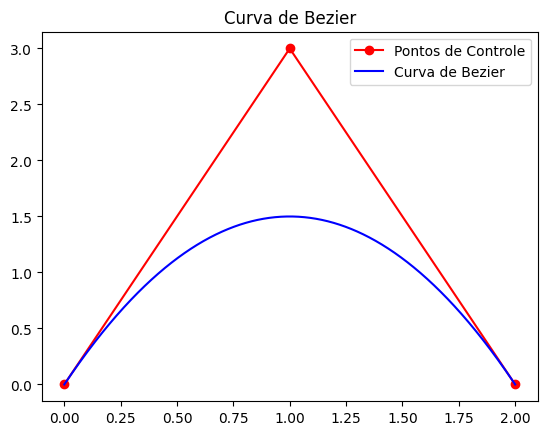

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def bezier(t, control_points):
    n = len(control_points) - 1
    result = np.zeros_like(control_points[0], dtype=float)
    
    for i in range(n + 1):
        result += (np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n - i))) * \
                  ((1 - t) ** (n - i)) * (t ** i) * control_points[i]

    return result

def plot_bezier_curve(control_points):
    t_values = np.linspace(0, 1, 1000)
    curve_points = np.array([bezier(t, control_points) for t in t_values])

    plt.plot(control_points[:, 0], control_points[:, 1], 'ro-', label='Pontos de Controle')
    plt.plot(curve_points[:, 0], curve_points[:, 1], 'b-', label='Curva de Bezier')
    plt.title('Curva de Bezier')
    plt.legend()
    plt.show()

# Exemplo de uso
control_points = np.array([[0.0, 0.0], [1.0, 3.0], [2.0, 0.0]])
plot_bezier_curve(control_points)
